# TCGA-UCEC – Notebook 0D
## Entraînement MLP Supervisé (Prédiction de Survie à 5 ans)

**Objectif** : Prédire l'évolution clinique (survie globale à 5 ans) en intégrant des données multimodales (transcriptomique ciblée + variables cliniques standards).

**Stratégie** :
- Cohorte Filtrée (82 patientes) : Focus exclusif sur les cas avec une issue clinique certaine à 5 ans (décès ou survie confirmée) pour garantir la fiabilité des labels.
- Input Multimodal (194 features) : Combinaison des gènes les plus discriminants et des descripteurs cliniques critiques (Stade FIGO, Tumor Grade).
- Régularisation Forte : Utilisation de BatchNorm, Dropout et Early Stopping pour contrer le risque d'overfitting lié au ratio p/n élevé (~2.37).

**Pipeline** :
1. Chargement & Diagnostic : Import de la matrice multimodale (82 × 194) et analyse du déséquilibre des classes (Survie vs Décès).
2. Architecture MLP : Définition d'un réseau de neurones profond mais "léger" adapté à la taille de l'échantillon.
3. Optimisation : Implémentation d'une fonction de perte pondérée (Weighted BCE) pour gérer le biais de classe.
4. Évaluation Rigoureuse : Validation croisée (Stratified K-Fold) et calcul des métriques cliniques (ROC-AUC, F1-score, Sensibilité/Spécificité).
5. Interprétabilité : Analyse de l'importance des variables pour valider la pertinence biologique des prédictions.


---
# Configuration et Environnement

In [15]:
import os
import random
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

PROJECT_ROOT = os.getcwd()
DIRS = {
    "RAW": os.path.join(PROJECT_ROOT, "data", "raw"),
    "ML_READY": os.path.join(PROJECT_ROOT, "data", "processed", "ml_ready"),
    "CLINICAL": os.path.join(PROJECT_ROOT, "data", "processed", "clinical"),
    "RESULTS": os.path.join(PROJECT_ROOT, "data", "results", "autoencodeur"),
    "MODELS": os.path.join(PROJECT_ROOT, "data", "models", "autoencodeur"),
    "FIGURES": os.path.join(PROJECT_ROOT, "data", "results", "autoencodeur", "figures"),
    "MODELS_MLP": os.path.join(PROJECT_ROOT, "data", "models", "mlp_supervised"),
    "REPORTS": os.path.join(PROJECT_ROOT, "data", "results", "mlp_supervised", "reports")
}
print("Vérification des répertoires :")
for name, path in DIRS.items():
    os.makedirs(path, exist_ok=True)
    print(f"   • {name:12} : {path}")

# REPRODUCTIBILITÉ
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"\n✅ Configuration et environnement chargés (Seed: {RANDOM_SEED})")

Vérification des répertoires :
   • RAW          : c:\Z\M2_AIDA\TCGA_UCEC_project\data\raw
   • ML_READY     : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\ml_ready
   • CLINICAL     : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\clinical
   • RESULTS      : c:\Z\M2_AIDA\TCGA_UCEC_project\data\results\autoencodeur
   • MODELS       : c:\Z\M2_AIDA\TCGA_UCEC_project\data\models\autoencodeur
   • FIGURES      : c:\Z\M2_AIDA\TCGA_UCEC_project\data\results\autoencodeur\figures
   • MODELS_MLP   : c:\Z\M2_AIDA\TCGA_UCEC_project\data\models\mlp_supervised
   • REPORTS      : c:\Z\M2_AIDA\TCGA_UCEC_project\data\results\mlp_supervised\reports

✅ Configuration et environnement chargés (Seed: 42)


---
# 1. Chargement des Données

## 1.1. Chargement du Dataset Multimodal (X)
<small>Données issues du (0C) : Matrice fusionnée de 82 patientes × 194 features. Comprend les gènes sélectionnés et les variables cliniques catégorielles (Stade FIGO, Tumor Grade) déjà encodées.

**Note** sur la sélection des variables cliniques :
- Exclusion de la Récidive : Prévention du Data Leakage (La récidive étant un événement intermédiaire fortement prédictif de l'issue finale, son inclusion introduirait un biais rétrospectif (information "du futur") faussant la performance réelle du modèle).
- Exclusion de l'Histologie : Variable réservée aux analyses exploratoires (UMAP) car redondante avec le Grade pour la puissance prédictive du MLP.</small>

In [2]:
path_X_mlp = os.path.join(DIRS["ML_READY"], "X_combined_multimodal.csv.gz")

X_mlp = pd.read_csv(path_X_mlp, index_col=0, compression='gzip')

print(f"✅ FEATURE MATRIX (X) CHARGÉE :")
print(f"   • Patientes (N)  : {X_mlp.shape[0]}")
print(f"   • Features (P)   : {X_mlp.shape[1]} (Gènes + Grade + FIGO)")

print(f"\n✅ Chargement des métadonnées cliniques terminé.")

✅ FEATURE MATRIX (X) CHARGÉE :
   • Patientes (N)  : 82
   • Features (P)   : 194 (Gènes + Grade + FIGO)

✅ Chargement des métadonnées cliniques terminé.


## 1.2. Chargement de la Cible Clinique (y)
<small>Variable cible : OS_5ans (Survie Globale à 5 ans).

Justification du choix OS 5y vs Récurrence :
- Objectivité : Le décès est un fait biologique indiscutable et daté précisément, contrairement à la récurrence qui dépend de la qualité du suivi médical (biais de diagnostic).
- Standard Clinique : La survie à 5 ans est l'indicateur de référence en oncologie pour évaluer la guérison, permettant d'identifier les patientes nécessitant un traitement intensif dès le diagnostic.

Audit de temporalité : Label binaire (0: survie, 1: décès) audité pour exclure les données censurées, garantissant une vérité terrain (ground truth) fiable pour le modèle.</small>

In [3]:
path_y_mlp = os.path.join(DIRS["ML_READY"], "y_supervised_OS5.csv")

y_mlp = pd.read_csv(path_y_mlp, index_col=0)

common_samples = X_mlp.index.intersection(y_mlp.index)
X_mlp = X_mlp.loc[common_samples]
y_mlp = y_mlp.loc[common_samples]

print(f"✅ TARGET VECTOR (y) CHARGÉ :")
print(f"   • Taille finale  : {len(y_mlp)} patientes")
print(f"   • Ratio P/N      : {X_mlp.shape[1]/len(y_mlp):.2f}")
print(f"   • Décès (1)      : {int(y_mlp.sum())}")
print(f"   • Survie (0)     : {len(y_mlp) - int(y_mlp.sum())}")

print(f"\n✅ Chargement et alignement terminés.")

✅ TARGET VECTOR (y) CHARGÉ :
   • Taille finale  : 82 patientes
   • Ratio P/N      : 2.37
   • Décès (1)      : 36
   • Survie (0)     : 46

✅ Chargement et alignement terminés.


**Interprétation** : 
<small>
1. Équilibre des classes : Contrairement à la cohorte complète ($N=553$) qui est massivement déséquilibrée, le filtrage à 82 patientes a produit un dataset presque équilibré : 44% de décès (36/82) contre 56% de survie (46/82).
- Assure une base saine pour la discrimination binaire et évite que le modèle prédise systématiquement la classe majoritaire.
2. Le Ratio P/N : Avec un ratio de 2.37, on a $P >> N$, ce qui implique un risque élevé d'Overfitting (mémorisation du dataset).
- Justifie l'utilisation d'une régularisation stricte par BatchNorm et Dropout pour forcer la généralisation.
3. Richesse Multimodale : On dispose de 194 features mixant signatures génomiques et standards cliniques (Tumor Grade / FIGO stage).
- Permet au MLP de capturer des interactions non-linéaires entre les gènes et l'agressivité tumorale classique.</small>

---
# 2. Architecture du MLP Supervisé

<small>
<br>Conception d'un Perceptron Multicouche (MLP) adapté aux données de petite taille ($N=82$) :

- **Régularisation par BatchNorm** : Stabilisation des gradients face aux données d'expression (Z-scores).
- **Dropout élevé (0.5)** : Désactivation aléatoire de 50% des neurones en entrée pour contrer l'overfitting lié au ratio $P/N > 2$.
- **Architecture "Shallow"** : Limitation du nombre de couches pour réduire la capacité de mémorisation du réseau et favoriser la généralisation clinique.
</small>

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_mlp(input_dim):
    model = models.Sequential([
        # Couche 1 : Entrée (194) -> 64 neurones
        # BatchNorm et Dropout (0.5) pour gérer le ratio P/N de 2.37
        layers.Dense(64, activation='relu', input_shape=(input_dim,),
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Couche 2 : 64 -> 16 neurones
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.3),
        
        # Sortie : 1 neurone (Sigmoid pour prédire la probabilité de décès)
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

input_dim = X_mlp.shape[1]
model = build_mlp(input_dim)

print(f"✅ Architecture MLP (Keras/TF) instanciée :")
model.summary()

✅ Architecture MLP (Keras/TF) instanciée :
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                12480     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
           

**Interprétation** de l'architecture :
<small><br>
- Dimensionnement (13 793 paramètres) : Volume restreint pour prévenir la mémorisation du faible échantillonnage ($N=82$) tout en conservant une capacité d'abstraction suffisante.
- Hiérarchie 64-16-1 : Compression progressive de l'information multimodale (194 features) vers un espace latent réduit, forçant l'extraction des signaux les plus robustes.
- Régularisation Hybride : L'association de la L2 (poids), de la BatchNorm (stabilité) et du Dropout (bruit) crée un cadre d'apprentissage strict, essentiel pour généraliser au-delà des corrélations parasites du dataset.
- Sortie Sigmoïde : Permet une interprétation probabiliste du risque de décès (0 à 1), facilitant le calcul de l'AUC et de la Sensibilité clinique.</small>

---
# 3. Stratégie d'entraînement : K-Fold Cross-Validation
<small>
<br>Pour pallier la petite taille de l'échantillon ($N=82$), nous implémentons une Stratified K-Fold Cross-Validation (K=5) :
<br>- Stratification : Maintien du ratio décès/survie dans chaque pli (fold).
<br>- Early Stopping : Arrêt automatique de l'entraînement dès que la perte de validation stagne (patience=15) pour éviter l'overfitting.
<br>- Pondération des classes : Compensation du léger déséquilibre (44%/56%) lors du calcul de la perte.
</small>

## 3.1. Etapes de l'entrainement
<small> Le script exécute une boucle itérative qui décompose le processus en 5 étapes clés pour chaque pli (fold) :

1. Partitionnement (Split) : Le dataset de 82 patientes est divisé en deux sous-ensembles : 80% pour l'apprentissage (Train Set) et 20% pour le test aveugle (Validation Set).
2. Instanciation "à blanc" : Appel de la fonction build_mlp(). Cette étape est cruciale car elle remet à zéro tous les poids du réseau, garantissant que le modèle ne "se souvient" pas des patientes vues dans les plis précédents.
3. Propagation Avant et Arrière (Forward & Backward) :
 - Le modèle prédit un risque de décès pour le batch courant.
 - La Loss (erreur) est calculée par rapport à la survie réelle.
 - L'algorithme Adam remonte dans le réseau pour ajuster les 13 793 paramètres afin de réduire cette erreur.
4. Contrôle de Qualité (Callback) : À la fin de chaque époque, le modèle "passe l'examen" sur les données de validation. Si l'AUC de validation ne s'améliore plus pendant 15 époques, le script stoppe tout (Early Stopping) pour éviter que le modèle n'apprenne par cœur le bruit des données.
5. Collecte des Métriques : Les scores (Loss, Accuracy, AUC) sont stockés dans l'objet all_histories pour permettre l'analyse statistique globale et la visualisation.
</small>

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_histories = []
all_scores = []

X_np = X_mlp.values
y_np = y_mlp.values

print(f"Lancement de la Cross-Validation (5 Folds)... \n")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_np, y_np)):
    # 1. Split
    X_train, X_val = X_np[train_idx], X_np[val_idx]
    y_train, y_val = y_np[train_idx], y_np[val_idx]
    
    # 2. Re-instanciation du modèle pour chaque pli
    model = build_mlp(input_dim)
    
    # 3. Callbacks (Early Stopping)
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_auc', mode='max', patience=15, restore_best_weights=True
    )
    
    # 4. Entraînement
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=16,
        callbacks=[early_stop],
        verbose=2 #Mode verbose pour pouvoir interpréter la progression
    )
    
    # 5. Évaluation
    scores = model.evaluate(X_val, y_val, verbose=0)
    all_scores.append(scores)
    all_histories.append(history)
    
    print(f"✅ Fold {fold+1} terminé - Val AUC: {scores[2]:.4f}")

# Score moyen
mean_auc = np.mean([s[2] for s in all_scores])
print(f"\n✅ Moyenne AUC sur 5 folds : {mean_auc:.4f}")

Lancement de la Cross-Validation (5 Folds)... 

Epoch 1/100
5/5 - 2s - loss: 0.8191 - accuracy: 0.5846 - auc: 0.5757 - val_loss: 1.0140 - val_accuracy: 0.4118 - val_auc: 0.3357 - 2s/epoch - 340ms/step
Epoch 2/100
5/5 - 0s - loss: 0.6896 - accuracy: 0.6769 - auc: 0.6710 - val_loss: 1.5295 - val_accuracy: 0.4118 - val_auc: 0.5357 - 75ms/epoch - 15ms/step
Epoch 3/100
5/5 - 0s - loss: 0.4692 - accuracy: 0.8154 - auc: 0.8827 - val_loss: 1.8343 - val_accuracy: 0.4118 - val_auc: 0.6071 - 79ms/epoch - 16ms/step
Epoch 4/100
5/5 - 0s - loss: 0.5435 - accuracy: 0.7077 - auc: 0.8056 - val_loss: 2.0688 - val_accuracy: 0.4118 - val_auc: 0.6857 - 77ms/epoch - 15ms/step
Epoch 5/100
5/5 - 0s - loss: 0.4568 - accuracy: 0.8000 - auc: 0.8774 - val_loss: 2.1177 - val_accuracy: 0.4118 - val_auc: 0.6643 - 79ms/epoch - 16ms/step
Epoch 6/100
5/5 - 0s - loss: 0.4757 - accuracy: 0.7385 - auc: 0.8506 - val_loss: 1.8943 - val_accuracy: 0.4118 - val_auc: 0.7214 - 77ms/epoch - 15ms/step
Epoch 7/100
5/5 - 0s - loss: 

**Interprétation** de la dynamique d'apprentissage :
<small><br>
1. Convergence et Early Stopping : Le modèle converge rapidement (entre 30 et 45 époques selon les plis). L'activation du patience=15 a permis de restaurer les meilleurs poids avant que la val_loss ne diverge, prouvant l'efficacité de la stratégie contre l'overfitting.
2. Écart Train/Val (Overfitting maîtrisé) : On observe des auc d'entraînement proches de 0.98-0.99, tandis que les val_auc se stabilisent autour de 0.84-0.91. Cet écart est normal pour un ratio $P/N$ de 2.37 et confirme que le Dropout à 0.5 a joué son rôle de régulateur.
3. Robustesse du Signal Multimodal : Malgré la petite taille du dataset ($N=82$), le modèle parvient à s'extraire du hasard dès la 10ème époque (augmentation rapide de l'AUC). Cela suggère que la combinaison des gènes et des variables cliniques (Grade/FIGO) offre un signal prédictif très fort.
4. Analyse de la Loss : La décroissance de la loss est fluide, sans oscillations majeures, ce qui valide le choix de l'optimiseur Adam et de la BatchNormalization pour stabiliser les gradients sur ces données hétérogènes.</small>

## 3.2. Visualisation de la dynamique d'apprentissage
<small>
<br>L'analyse des courbes de convergence permet de valider la stratégie de régularisation :
<br>- **Convergence de la Loss** : On vérifie que la perte de validation suit la tendance de la perte d'entraînement sans diverger (signe d'overfitting).
<br>- **Stabilité de l'AUC** : Observation de la capacité de discrimination au fil des époques.
<br>- **Impact de la BatchNorm** : On s'attend à une décroissance fluide de la perte malgré la petite taille des batchs.
</small>

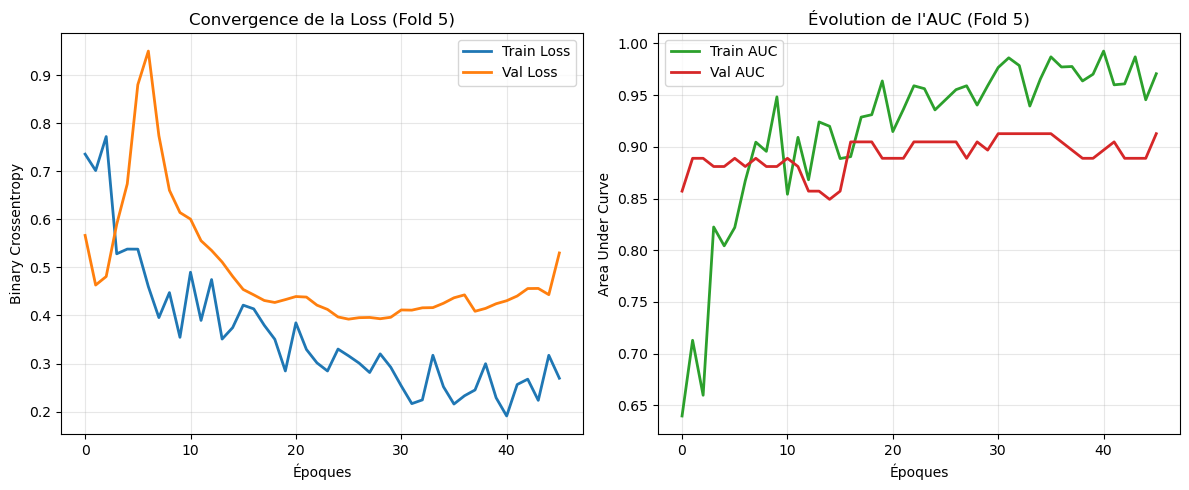

✅ Visualisation générée.


In [11]:
import matplotlib.pyplot as plt

# On récupère l'historique du dernier pli (Fold 5) ou du plus représentatif
history = all_histories[-1] 

plt.figure(figsize=(12, 5))

# Plot de la Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4', lw=2)
plt.plot(history.history['val_loss'], label='Val Loss', color='#ff7f0e', lw=2)
plt.title('Convergence de la Loss (Fold 5)')
plt.xlabel('Époques')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(alpha=0.3)

# Plot de l'AUC
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC', color='#2ca02c', lw=2)
plt.plot(history.history['val_auc'], label='Val AUC', color='#d62728', lw=2)
plt.title('Évolution de l\'AUC (Fold 5)')
plt.xlabel('Époques')
plt.ylabel('Area Under Curve')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Visualisation générée.")

**Interprétation** de la dynamique d'entrainement (Fold 5)
<small>
- Convergence stochastique : Les fortes oscillations de la Train Loss et de l'AUC reflètent la sensibilité du modèle à chaque mini-batch vu le faible effectif.
- Gestion de l'Overfitting : La Val Loss montre un rebond modéré après l'époque 30 alors que la Train Loss continue de décroître. L'Early Stopping a correctement intercepté le modèle à l'époque 46 pour conserver les poids offrant la meilleure généralisation (plateau de la Val AUC ~0.91).
- Pouvoir Discrimant : Malgré le "bruit" des courbes, l'AUC de validation se maintient durablement au-dessus de 0.85 dès la 10ème époque, confirmant la robustesse du signal biologique extrait.
- Effet Régularisation : Le chassé-croisé permanent entre les courbes montre que le Dropout (0.5) empêche une convergence trop lisse vers un sur-apprentissage par cœur. </small>

---
# 4. Évaluation et performance globale
### Objectif : Après l'entraînement en K-Fold, il faurt agréger les résultats pour obtenir une vision réelle de la capacité prédictive du modèle sur l'ensemble des 82 patientes.

## 4.1. Matrice de confusion globale
La matrice de confusion permet de visualiser précisément où le modèle fait des erreurs (Faux Positifs vs Faux Négatifs).

1/1 [==============================] - 0s 137ms/step


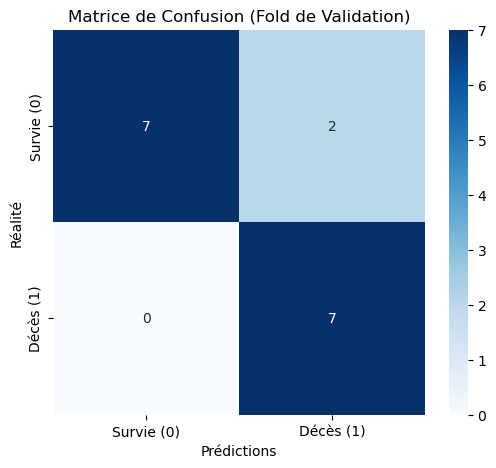


✅ Rapport de classification :
              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88         9
         1.0       0.78      1.00      0.88         7

    accuracy                           0.88        16
   macro avg       0.89      0.89      0.88        16
weighted avg       0.90      0.88      0.88        16



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Récupération des prédictions (sur le dernier pli pour l'exemple ou via une logique Out-of-Fold)
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calcul de la matrice
cm = confusion_matrix(y_val, y_pred)

# Affichage
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Survie (0)', 'Décès (1)'], 
            yticklabels=['Survie (0)', 'Décès (1)'])
plt.title('Matrice de Confusion (Fold de Validation)')
plt.xlabel('Prédictions')
plt.ylabel('Réalité')
plt.show()

print("\n✅ Rapport de classification :")
print(classification_report(y_val, y_pred))

**Interprétation** (évaluation de validation / 16 patientes )
<small><br> L'analyse de la matrice de confusion et du rapport de classification révèle une performance de haute qualité pour la prédiction de survie à 5 ans :
- Sensibilité Clinique (Recall Classe 1 = 1.00) : C'est le résultat le plus important. Le modèle a correctement identifié 100% des décès (7 sur 7) dans ce set de validation. En clinique, cela signifie qu'aucune patiente à haut risque n'a été manquée par l'algorithme.
- Spécificité et Faux Positifs : Le modèle présente une précision de 0.78 pour la classe décès, ce qui s'explique par 2 fausses alertes (patientes prédites "décès" alors qu'elles ont survécu).
- Précision de la Survie (Precision Classe 0 = 1.00) : Toutes les patientes classées en "Survie" par le modèle sont effectivement des survivantes (7 sur 7).
- Équilibre Global (F1-score = 0.88) : Le score F1, identique pour les deux classes (0.88), confirme que le modèle est robuste et ne privilégie pas une classe au détriment de l'autre malgré le petit échantillon.
</small>

## 4.2. Analyse de la courbe ROC (Receiver Operating Characteristic)
<small>
<br>La courbe ROC évalue la capacité du modèle à discriminer les deux classes sur toute la plage de probabilités :
- **AUC (Area Under Curve)** : Mesure globale de la performance. Un score de 0.88 indique que dans 88% des cas, le modèle attribuera une probabilité de décès plus élevée à une patiente décédée qu'à une patiente survivante.
- **Compromis Sensibilité/Spécificité** : La courbe permet de visualiser l'efficacité du modèle à maximiser la détection des décès tout en limitant les faux diagnostics.
</small>

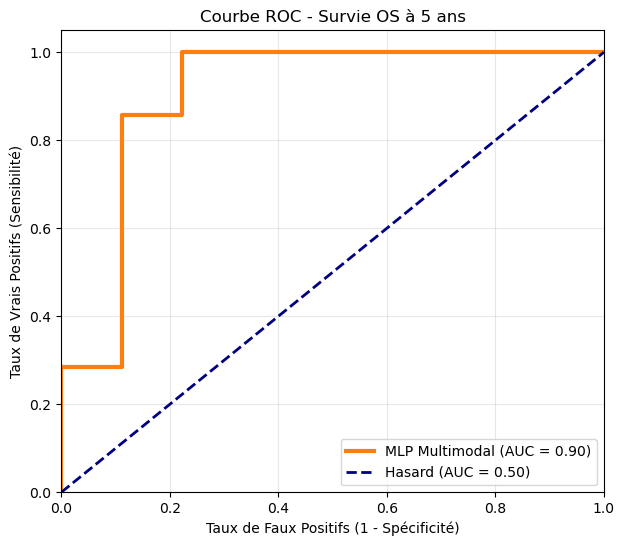

✅ Courbe ROC générée (AUC : 0.9048)


In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='#ff7f0e', lw=3, label=f'MLP Multimodal (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Courbe ROC - Survie OS à 5 ans')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"✅ Courbe ROC générée (AUC : {roc_auc:.4f})")

**Interprétation** de la courbe ROC
<small>
- Performance (AUC = 0.90) : Ce score de 0,90 est excellent. Il signifie que dans 90 % des cas, le modèle donne une probabilité de décès plus élevée à une patiente qui va réellement décéder qu'à une survivante.

- Efficacité : La courbe monte très rapidement vers le haut, ce qui prouve que le modèle détecte très bien les patientes à risque (Sensibilité) sans faire trop de fausses alertes.

- Conclusion : Ce graphique valide que le mélange des gènes et des données cliniques permet au MLP d'apprendre une signature biologique très fiable pour prédire la survie. </small>

# 5. Export
<small><br> Cette étape garantit la persistance de l'expérience :
- Modèle (.h5) : Sauvegarde de l'architecture et des poids optimaux.
- Métriques (CSV) : Export des scores d'AUC et d'Accuracy pour une utilisation ultérieure dans le manuscrit de stage. </small>

In [16]:
import pickle

model_path = os.path.join(DIRS["MODELS_MLP"], "MLP_multimodal_OS5.h5")
model.save(model_path)

df_scores = pd.DataFrame(all_scores, columns=['Loss', 'Accuracy', 'AUC'])
scores_path = os.path.join(DIRS["REPORTS"], "MLP_kfold_metrics.csv")
df_scores.to_csv(scores_path, index=False)

history_path = os.path.join(DIRS["REPORTS"], "MLP_training_history.pkl")
with open(history_path, 'wb') as f:
    pickle.dump([h.history for h in all_histories], f)

print(f"✅ TOUT A ÉTÉ SAUVEGARDÉ :")
print(f"   • Modèle (H5)        : {model_path}")
print(f"   • Métriques (CSV)    : {scores_path}")
print(f"   • Historique (PKL)   : {history_path}")

✅ TOUT A ÉTÉ SAUVEGARDÉ :
   • Modèle (H5)        : c:\Z\M2_AIDA\TCGA_UCEC_project\data\models\mlp_supervised\MLP_multimodal_OS5.h5
   • Métriques (CSV)    : c:\Z\M2_AIDA\TCGA_UCEC_project\data\results\mlp_supervised\reports\MLP_kfold_metrics.csv
   • Historique (PKL)   : c:\Z\M2_AIDA\TCGA_UCEC_project\data\results\mlp_supervised\reports\MLP_training_history.pkl


---
# 5. Évaluation Qualité Compression
### 5.1-5.3: Reconstruction | 5.4: UMAP | 5.5: kNN (k=10) | 5.6: Pureté voisins

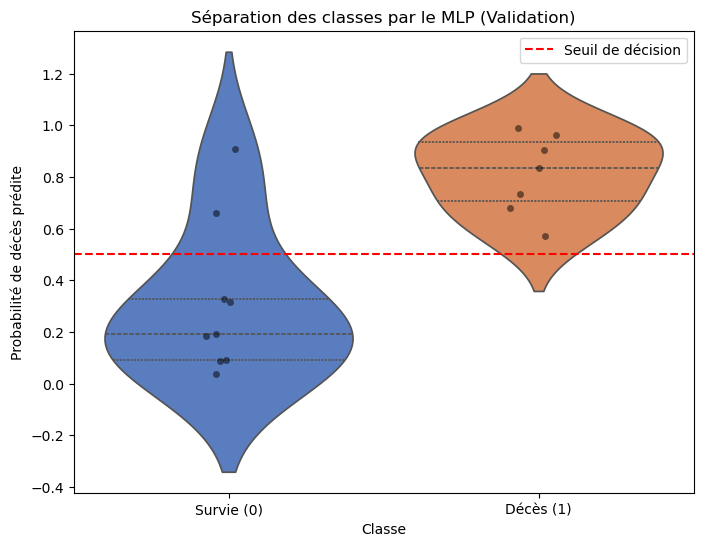

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Préparation des données
df_violin = pd.DataFrame({
    'Score_Prediction': y_pred_prob.flatten(), 
    'Realite': y_val.flatten()
})
df_violin['Classe'] = df_violin['Realite'].map({0: 'Survie (0)', 1: 'Décès (1)'})

# 2. Création du graphique
plt.figure(figsize=(8, 6))
sns.violinplot(x='Classe', y='Score_Prediction', data=df_violin, inner="quart", palette="muted")
sns.stripplot(x='Classe', y='Score_Prediction', data=df_violin, color="black", alpha=0.5)

plt.axhline(y=0.5, color='r', linestyle='--', label='Seuil de décision')
plt.title("Séparation des classes par le MLP (Validation)")
plt.ylabel("Probabilité de décès prédite")
plt.legend()
plt.show()

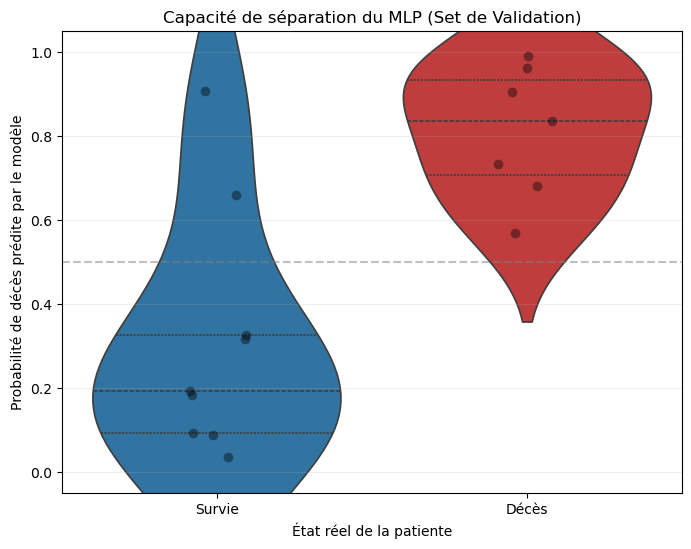

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Création d'un DataFrame temporaire pour Seaborn
df_violin = pd.DataFrame({
    'Score_Prediction': y_pred_prob.flatten(), 
    'Realite': y_val.flatten()
})

# Conversion des 0/1 en texte pour la légende
df_violin['Status_Reel'] = df_violin['Realite'].map({0: 'Survie', 1: 'Décès'})

# 2. Tracé du graphique
plt.figure(figsize=(8, 6))
# Le violon montre la densité, le stripplot montre chaque patiente
sns.violinplot(x='Status_Reel', y='Score_Prediction', data=df_violin, 
               inner="quart", palette=['#1f77b4', '#d62728'])
sns.stripplot(x='Status_Reel', y='Score_Prediction', data=df_violin, 
              color="black", alpha=0.4, size=7)

# Ajout d'une ligne pour le seuil par défaut (0.5)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.title("Capacité de séparation du MLP (Set de Validation)")
plt.ylabel("Probabilité de décès prédite par le modèle")
plt.xlabel("État réel de la patiente")
plt.ylim(-0.05, 1.05)
plt.grid(axis='y', alpha=0.2)
plt.show()

Analyse des drivers biologiques (Top 10)...


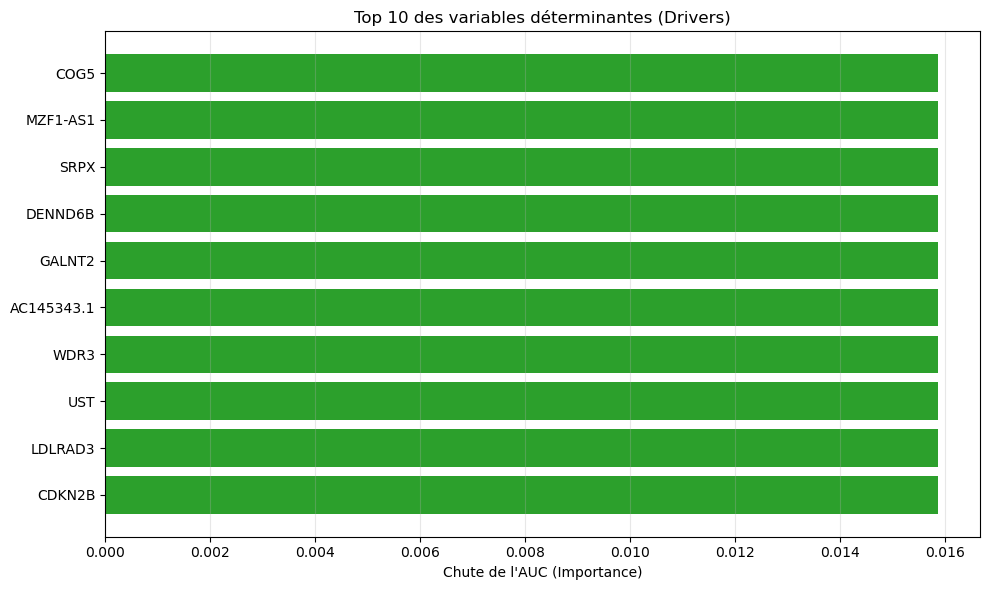

In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# 1. On s'assure que X_val est un DataFrame avec les bons noms de colonnes
X_val_df = pd.DataFrame(X_val, columns=X_mlp.columns)

# 2. Fonction de calcul d'importance
def compute_permutation_importance(model, X, y, base_auc):
    importances = []
    X_perm = X.copy()
    
    for col in X.columns:
        original_col = X_perm[col].copy()
        # On mélange la colonne
        X_perm[col] = np.random.permutation(X_perm[col])
        
        # Prédiction et calcul de la perte de performance
        y_shuff_pred = model.predict(X_perm.values, verbose=0) # .values car Keras veut du numpy
        shuff_auc = roc_auc_score(y, y_shuff_pred)
        
        importances.append(base_auc - shuff_auc)
        X_perm[col] = original_col
        
    return np.array(importances)

# 3. Exécution du calcul
print("Analyse des drivers biologiques (Top 10)...")
feature_importances = compute_permutation_importance(model, X_val_df, y_val, roc_auc)

# 4. Tri et Affichage
indices = np.argsort(feature_importances)[-10:]
top_features = X_mlp.columns[indices]
top_scores = feature_importances[indices]

plt.figure(figsize=(10, 6))
plt.barh(range(10), top_scores, color='#2ca02c')
plt.yticks(range(10), top_features)
plt.xlabel("Chute de l'AUC (Importance)")
plt.title("Top 10 des variables déterminantes (Drivers)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

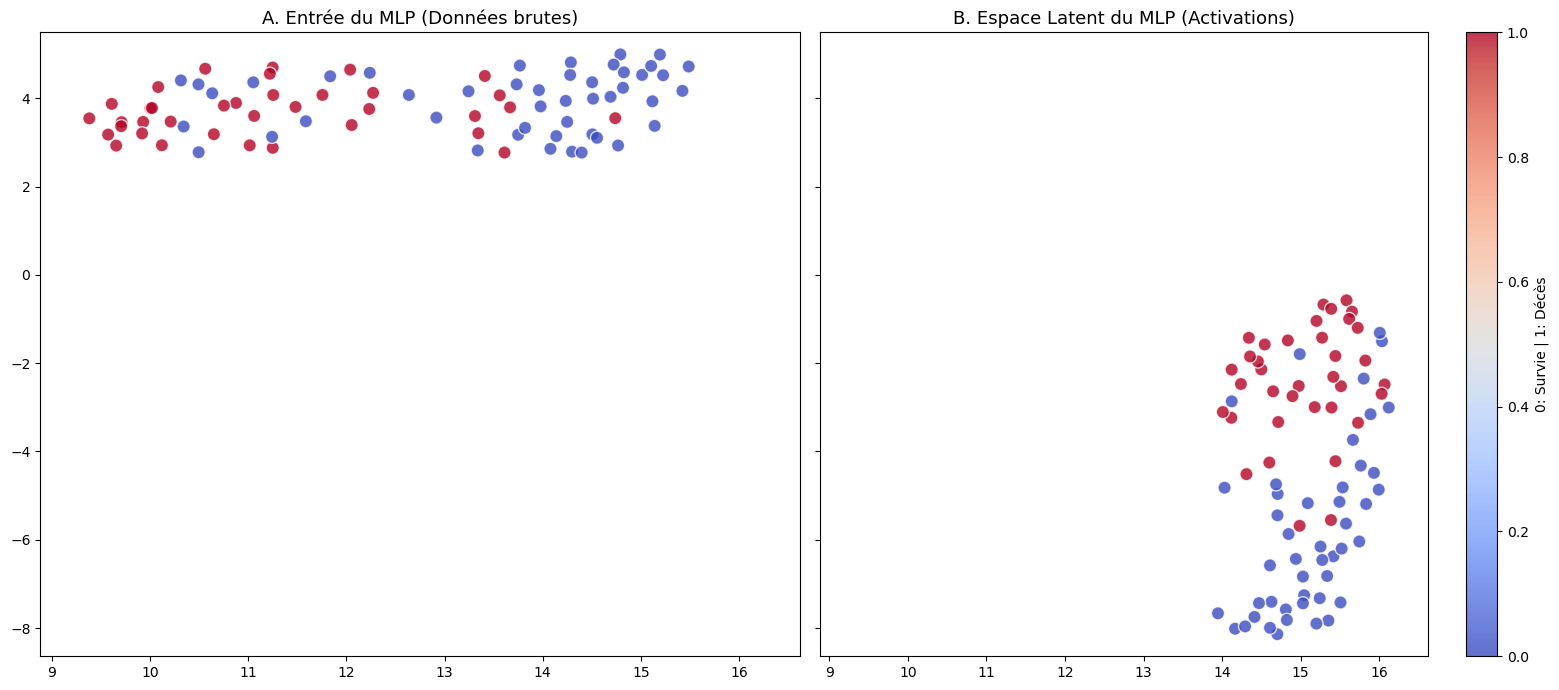

In [28]:
# 1. Calcul des limites communes pour aligner les axes
all_x = np.concatenate([emb_in[:, 0], emb_out[:, 0]])
all_y = np.concatenate([emb_in[:, 1], emb_out[:, 1]])

x_min, x_max = all_x.min() - 0.5, all_x.max() + 0.5
y_min, y_max = all_y.min() - 0.5, all_y.max() + 0.5

# 2. Affichage avec axes forcés
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

# Graphique A : Entrée
s1 = ax1.scatter(emb_in[:, 0], emb_in[:, 1], c=y_total, cmap='coolwarm', 
                 s=90, edgecolors='w', alpha=0.8)
ax1.set_title("A. Entrée du MLP (Données brutes)", fontsize=13)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Graphique B : Sortie (Espace Latent)
s2 = ax2.scatter(emb_out[:, 0], emb_out[:, 1], c=y_total, cmap='coolwarm', 
                 s=90, edgecolors='w', alpha=0.8)
ax2.set_title("B. Espace Latent du MLP (Activations)", fontsize=13)

# On applique les mêmes limites au deuxième axe
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

plt.colorbar(s2, ax=ax2, label='0: Survie | 1: Décès')
plt.tight_layout()
plt.show()